# Goodreads Book Ratings Predictions
![GoodReads](https://s.gr-assets.com/assets/facebook/goodreads_wide-e23f6858b6bf20dcaf8493237a214a0e.png)

### Content
1. Exploring Data.
2. Analyze Data through visualizations.
3. Data Preparation e.g.: [Ordinal Encoding, Handling Missing Values].
4. Feature Engineering.
5. Building Multiple Machine Learning Models.
6. Compare models accuracy on training data.
7. Make predictions using each model.
8. Compare models accuracy on test data.
9. Compare training VS test score for each model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Importing and Exploring Dataset

In [2]:
df = pd.read_csv('../input/goodreadsbooks/books.csv', error_bad_lines=False)
df.head()

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [3]:
df.describe() # Generate the summary table of the data

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,32104.500000,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


In [4]:
df.dtypes # Check the data types of all columns

bookID                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
  num_pages             int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object

In [5]:
df.isnull().sum() # Check if there's any missing value

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
  num_pages           0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

# 2. Data Cleaning & Feature Engineering

In [6]:
from sklearn.preprocessing import OrdinalEncoder

encoding = {'language_code':{'en-US': 'eng', 'en-GB': 'eng', 'en-CA': 'eng'}} # Unify the langauge codes
df.replace(encoding, inplace=True)

enc = OrdinalEncoder()
enc.fit(df[['language_code']])
df[['language_code']] = enc.fit_transform(df[['language_code']]) # Apply ordinal encoding on language_code to convert it into numerical column

In [7]:
df['publication_date'] = pd.to_datetime(df['publication_date'], format='%m/%d/%Y', errors='coerce') # Convert data type of publication_date from object into date type
df[df['publication_date'].isnull()]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
8177,31373,In Pursuit of the Proper Sinner (Inspector Lyn...,Elizabeth George,4.10,0553575104,9780553575101,2.0,718,10608,295,NaT,Bantam Books
11094,45531,Montaillou village occitan de 1294 à 1324,Emmanuel Le Roy Ladurie/Emmanuel Le Roy-Ladurie,3.96,2070323285,9782070323289,4.0,640,15,2,NaT,Folio histoire


### Since there are only 2 books with courrpted dates, I googled these 2 books to get the publication dates and put them manually

In [8]:
df.loc[df.bookID == 31373, 'publication_date'] = '1999-10-01 00:00:00'
df.loc[df.bookID == 45531, 'publication_date'] = '1975-10-01 00:00:00'

In [9]:
df['year'] = pd.DatetimeIndex(df['publication_date']).year # Extract year of publication in a separate column

df.rename(columns = {'  num_pages': 'num_pages'}, inplace=True) # Rename the column to remove leading whitespaces

In [10]:
df['num_occ'] = df.groupby('title')['title'].transform('count') # Add a new feature which has the number of occurences of each book

#### Calculating New Features

In [11]:
df['rate_occ'] = df['average_rating'] * df['num_occ']
df['rate_weight'] = df['average_rating'] * df['text_reviews_count']
df['rate_weight_2'] = df['average_rating'] * df['ratings_count']
df['rate_per_pages'] = df['average_rating'] * df['num_pages']

# 3. Data Analysis & Visualizations

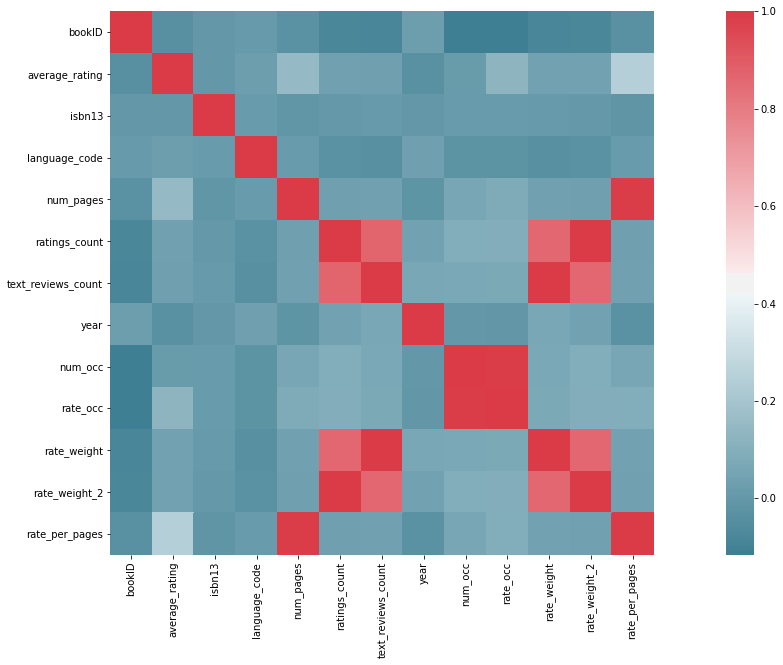

In [12]:
fig = plt.gcf()
fig.set_size_inches(26, 10)
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)

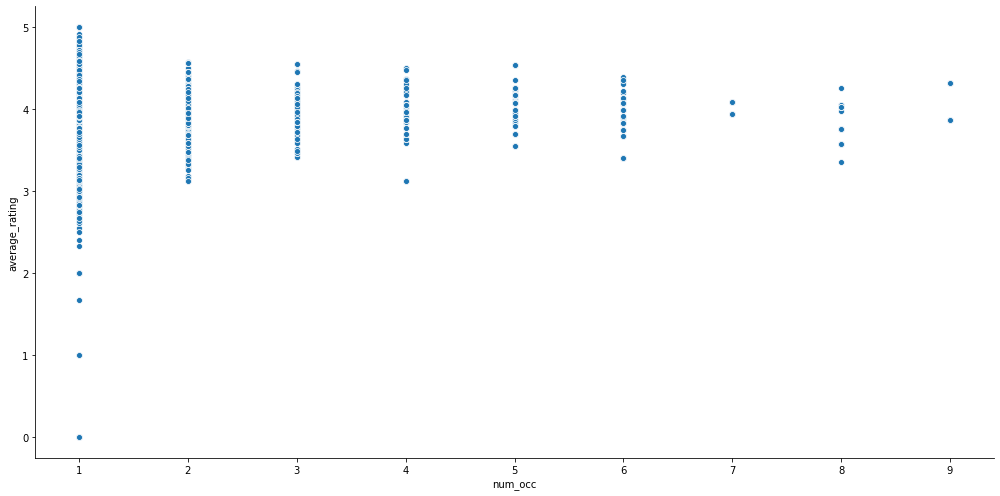

In [13]:
sns.relplot(x="num_occ", y="average_rating", data=df, height=7, aspect = 2)

#### The upper visual says that any book appeared more than once has a good/high rate

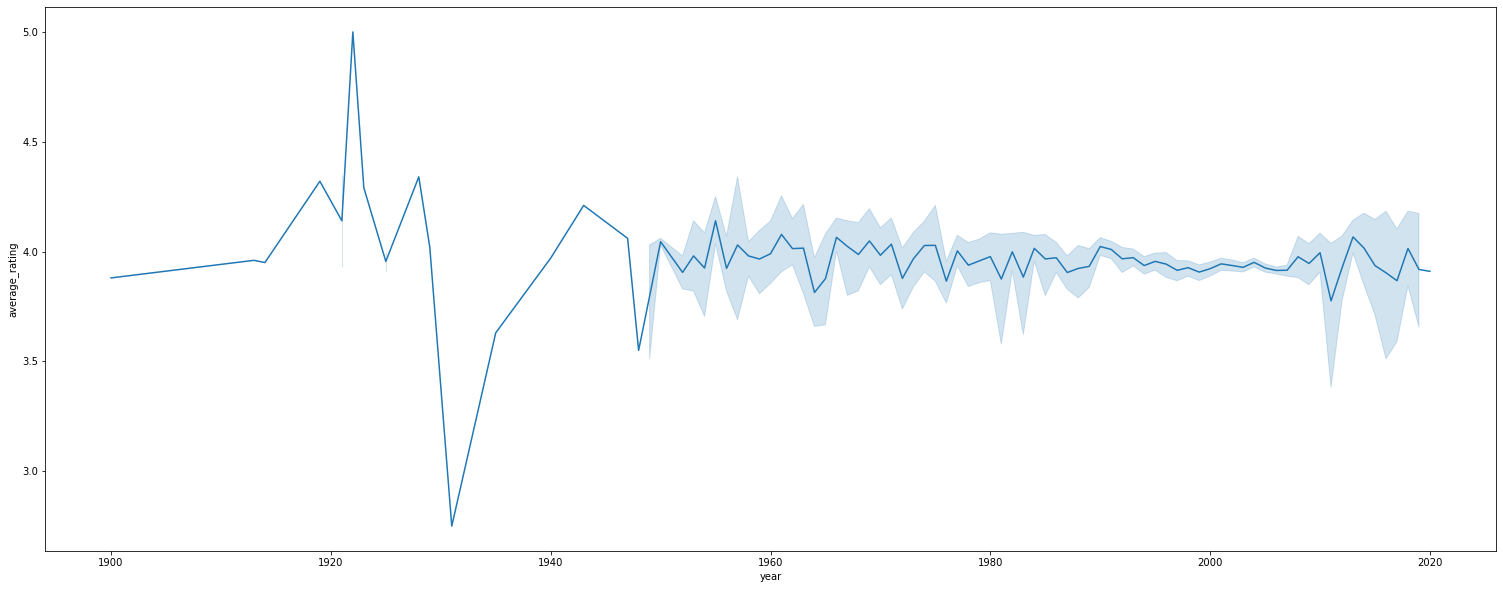

In [14]:
fig = plt.gcf()
fig.set_size_inches(26, 10)
sns.lineplot(x="year", y="average_rating", data=df)

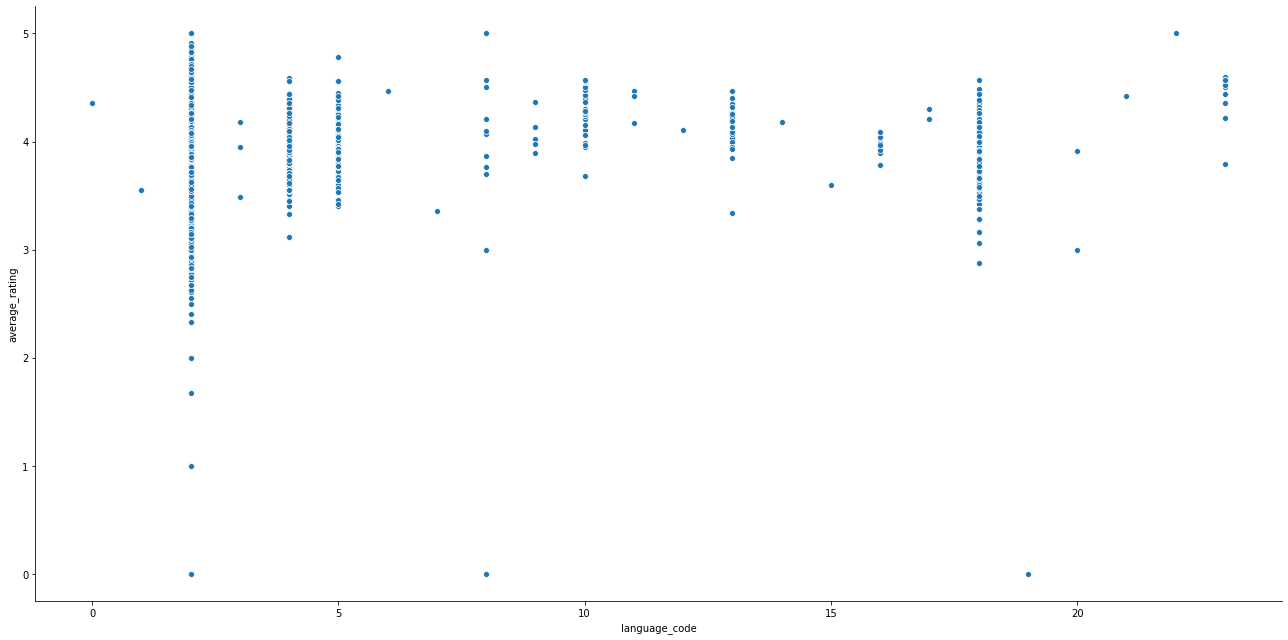

In [15]:
sns.relplot(x="language_code", y="average_rating", data=df, height=9, aspect = 2)

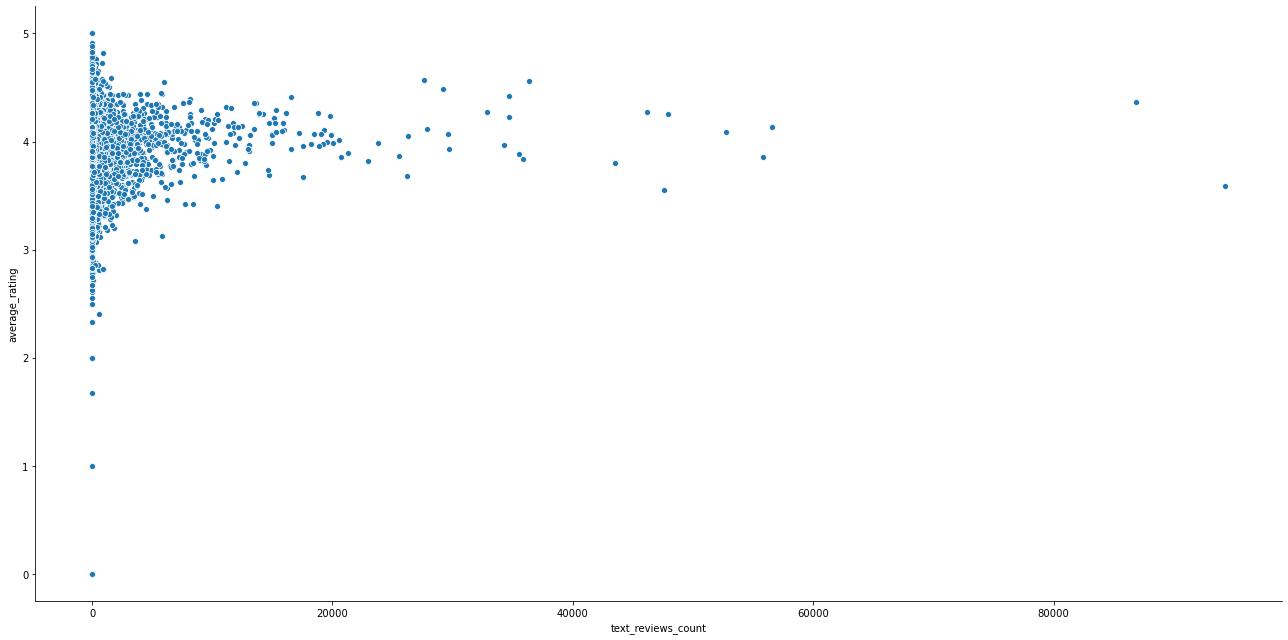

In [16]:
sns.relplot(x="text_reviews_count", y="average_rating", data=df, height=9, aspect = 2)

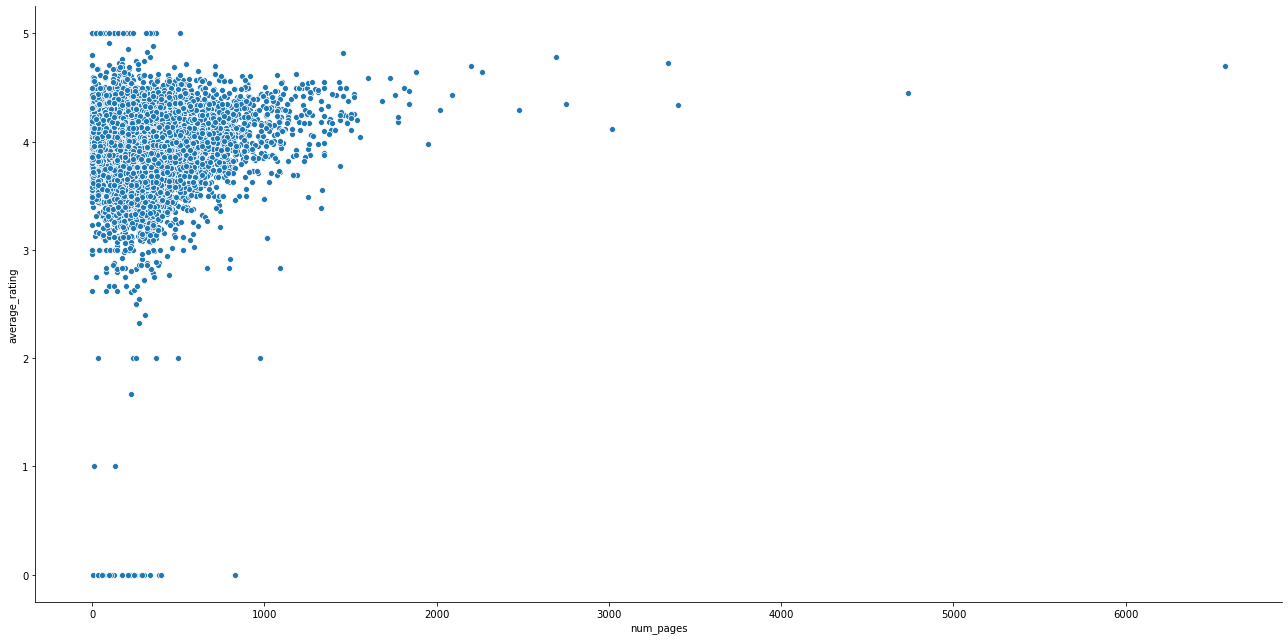

In [17]:
sns.relplot(x="num_pages", y="average_rating", data=df, height=9, aspect = 2)

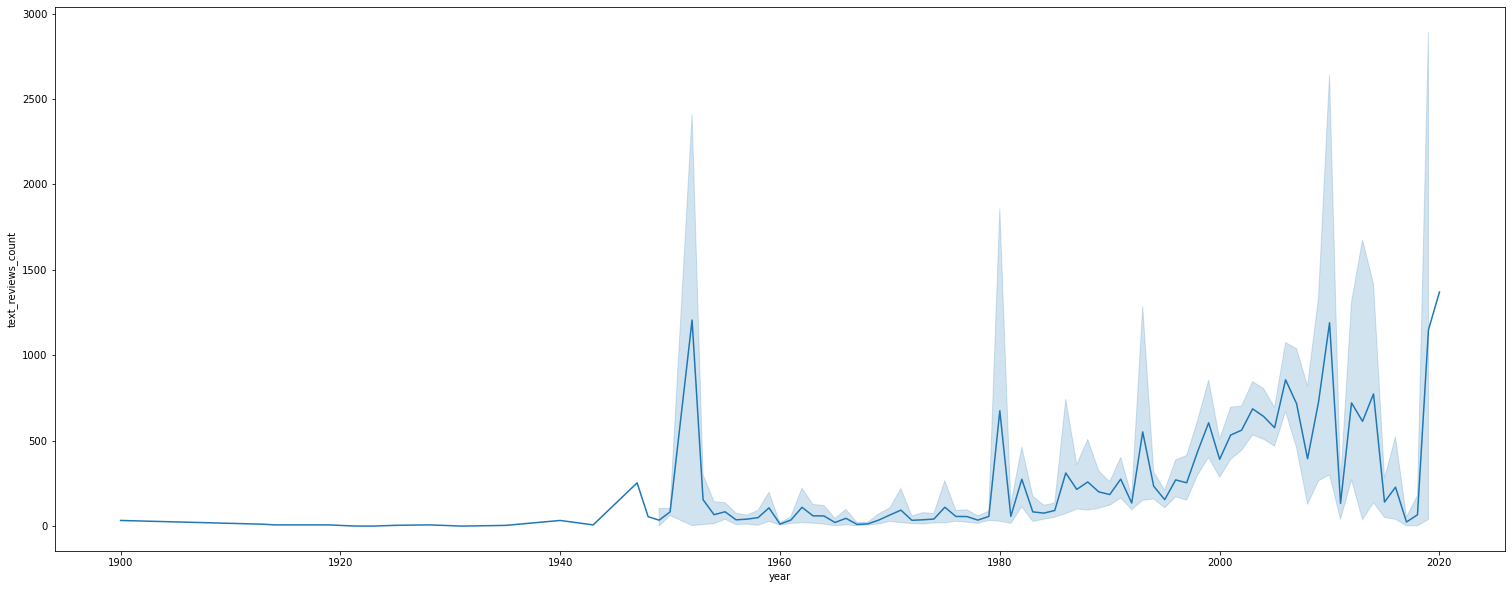

In [18]:
fig = plt.gcf()
fig.set_size_inches(26, 10)
sns.lineplot(x="year", y="text_reviews_count", data=df)

### We can see from the visual above that starting from the 80s, the rate/number of reviews is getting higher than before, We can say that this's the effect of the computer & internet

# 5. Creating Model

In [19]:
label = df['average_rating'].values
df.drop(['bookID', 'title', 'authors', 'isbn', 'isbn13', 'publication_date', 'publisher', 'average_rating'], axis=1, inplace=True)

In [20]:
# Split the Data into 70% - 30%
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.3)

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4))

parameters = {
    'learning_rate': [0.001, 0.01, 0.02, 0.1, 0.2, 1.0],
    'n_estimators': [10, 50, 100, 200]
}

grad_Ada = GridSearchCV(model, parameters, refit=True)
grad_Ada.fit(X_train, y_train)

print('Best Score: ', grad_Ada.best_score_*100, '\nBest Parameters: ', grad_Ada.best_params_)

Best Score:  93.63312569614041 
Best Parameters:  {'learning_rate': 0.1, 'n_estimators': 50}


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

model  = LinearRegression()

parameters = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    
}

grad_Linear = GridSearchCV(model, parameters, refit=True)
grad_Linear.fit(X_train, y_train)

print('Best Score: ', grad_Linear.best_score_*100, '\nBest Parameters: ', grad_Linear.best_params_)

Best Score:  79.38273905131311 
Best Parameters:  {'fit_intercept': True, 'normalize': True}


In [23]:
from sklearn.linear_model import Ridge

model = Ridge()

parameters = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'max_iter': [1000, 100, 10000],
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grad_ridge = GridSearchCV(model, parameters, refit=True)
grad_ridge.fit(X_train, y_train)

print('Best Score: ', grad_ridge.best_score_*100, '\nBest Parameters: ', grad_ridge.best_params_)

Best Score:  79.38510600541593 
Best Parameters:  {'alpha': 1, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False}


In [24]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

parameters = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7, 10, 12, 15],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [5, 10, 15]
}

grad_rf = GridSearchCV(model, parameters, refit=True, cv=10)
grad_rf.fit(X_train, y_train)

print('Best Score: ', grad_rf.best_score_*100, '\nBest Parameters: ', grad_rf.best_params_)

Best Score:  98.94148502878215 
Best Parameters:  {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 150}


In [25]:
l = []
l.append(('AdaBoost', grad_Ada.best_score_*100))
l.append(('Linear Regression', grad_Linear.best_score_*100))
l.append(('Ridge Regression', grad_ridge.best_score_*100))
l.append(('Random Forest', grad_rf.best_score_*100))
scores = pd.DataFrame(l, columns =['Model', 'Train Score'])

# 6. Make Predictions using the 4 Models

In [26]:
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

## AdaBoost Model

In [27]:
# AdaBoost Model
pred_adaboost = grad_Ada.predict(X_test)

# Check Model Score
print("Residual sum of squares: ",  np.mean((pred_adaboost - y_test) ** 2))
print('RMSE: '+str(np.sqrt(mean_squared_error(y_test, pred_adaboost))))
print('Model Score on Test Data: ', grad_Ada.score(X_test, y_test))

Residual sum of squares:  0.006302900342744974
RMSE: 0.07939080767157476
Model Score on Test Data:  0.9562224180416188


#### Features Importance

In [28]:
from eli5.sklearn import PermutationImportance
import eli5
perm = PermutationImportance(grad_Ada.best_estimator_, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
1.8855 ± 0.0608,rate_occ
0.2240 ± 0.0176,num_occ
0.0002 ± 0.0005,rate_per_pages
0.0000 ± 0.0000,rate_weight
0.0000 ± 0.0000,text_reviews_count
0.0000 ± 0.0000,year
0 ± 0.0000,language_code
-0.0001 ± 0.0003,num_pages
-0.0015 ± 0.0001,ratings_count
-0.0021 ± 0.0000,rate_weight_2


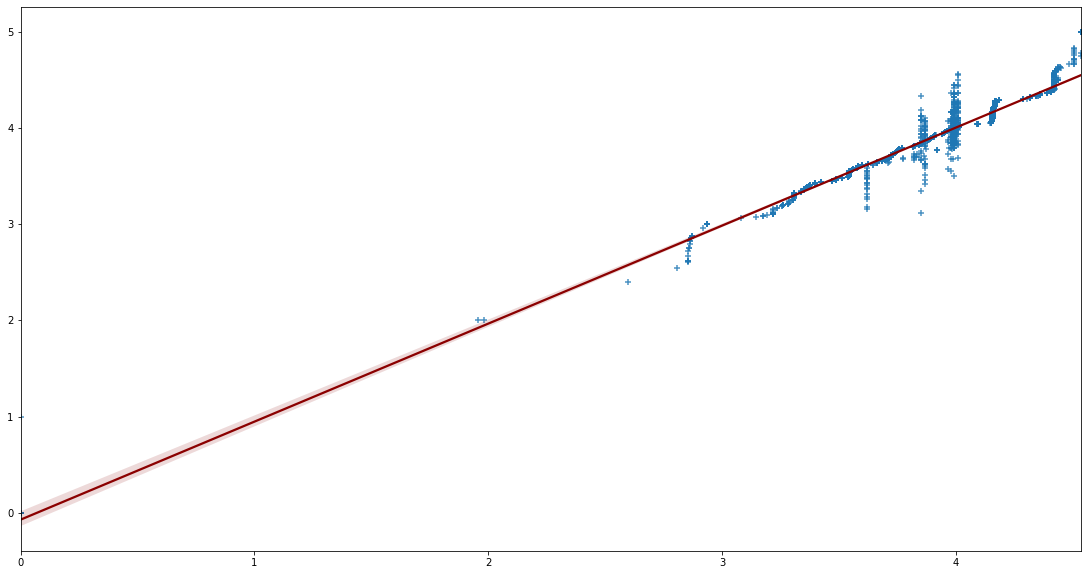

In [29]:
plt.figure(figsize=(19,10))
sns.regplot(pred_adaboost, y_test, marker="+", line_kws={'color':'darkred','alpha':1.0})

## Linear Regression Model

In [30]:
# Linear Regression Model
pred_lr = grad_Linear.predict(X_test)

# Check Model Score
print("Residual sum of squares: ",  np.mean((pred_lr - y_test) ** 2))
print('RMSE: '+str(np.sqrt(mean_squared_error(y_test, pred_lr))))
print('Model Score on Test Data: ', grad_Linear.score(X_test, y_test))

Residual sum of squares:  0.02388043819619859
RMSE: 0.15453296799129496
Model Score on Test Data:  0.8341354323427481


#### Features Importance

In [31]:
perm = PermutationImportance(grad_Linear.best_estimator_, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
39.7213 ± 1.5570,rate_occ
39.1357 ± 1.1362,num_occ
10.2007 ± 0.2552,rate_per_pages
9.3585 ± 0.1625,num_pages
0.6082 ± 0.0114,ratings_count
0.5855 ± 0.0151,rate_weight_2
0.3112 ± 0.0044,text_reviews_count
0.3038 ± 0.0111,rate_weight
0.0003 ± 0.0003,language_code
-0.0001 ± 0.0001,year


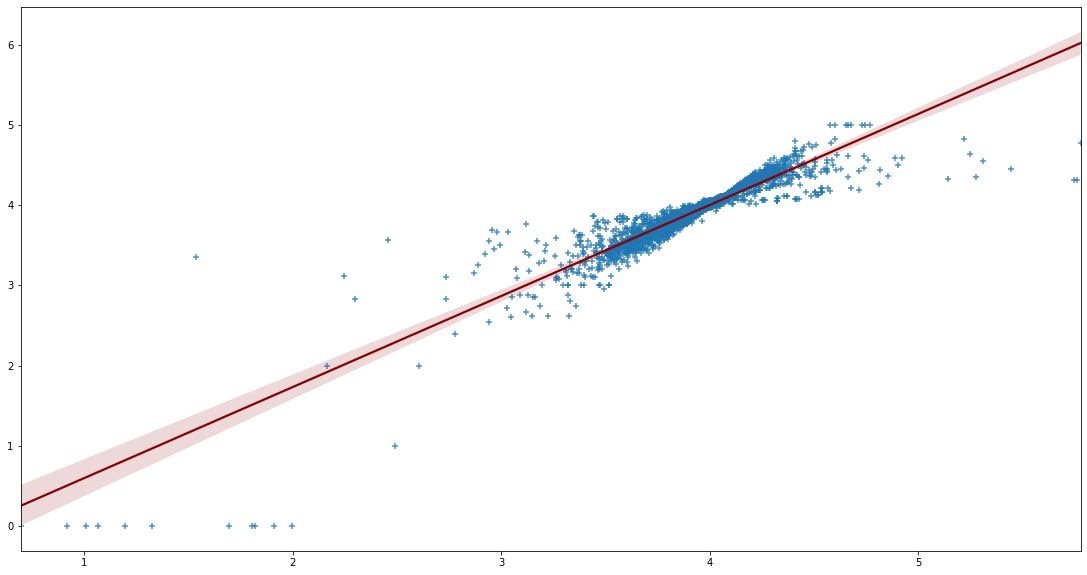

In [32]:
plt.figure(figsize=(19,10))
sns.regplot(pred_lr, y_test, marker="+", line_kws={'color':'darkred','alpha':1.0})

## Ridge Regression Model

In [33]:
# Ridge Regression Model
pred_ridge = grad_ridge.predict(X_test)

# Check Model Score
print("Residual sum of squares: ",  np.mean((pred_ridge - y_test) ** 2))
print('RMSE: '+str(np.sqrt(mean_squared_error(y_test, pred_ridge))))
print('Model Score on Test Data: ', grad_ridge.score(X_test, y_test))

Residual sum of squares:  0.024216536283647446
RMSE: 0.1556166324132721
Model Score on Test Data:  0.8318010210766262


#### Features Importance

In [34]:
perm = PermutationImportance(grad_ridge.best_estimator_, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
38.1688 ± 1.4985,rate_occ
37.5878 ± 1.0949,num_occ
10.7567 ± 0.2695,rate_per_pages
9.8684 ± 0.1707,num_pages
0.6057 ± 0.0113,ratings_count
0.5826 ± 0.0148,rate_weight_2
0.3231 ± 0.0044,text_reviews_count
0.3156 ± 0.0115,rate_weight
0.0003 ± 0.0004,language_code
-0.0001 ± 0.0001,year


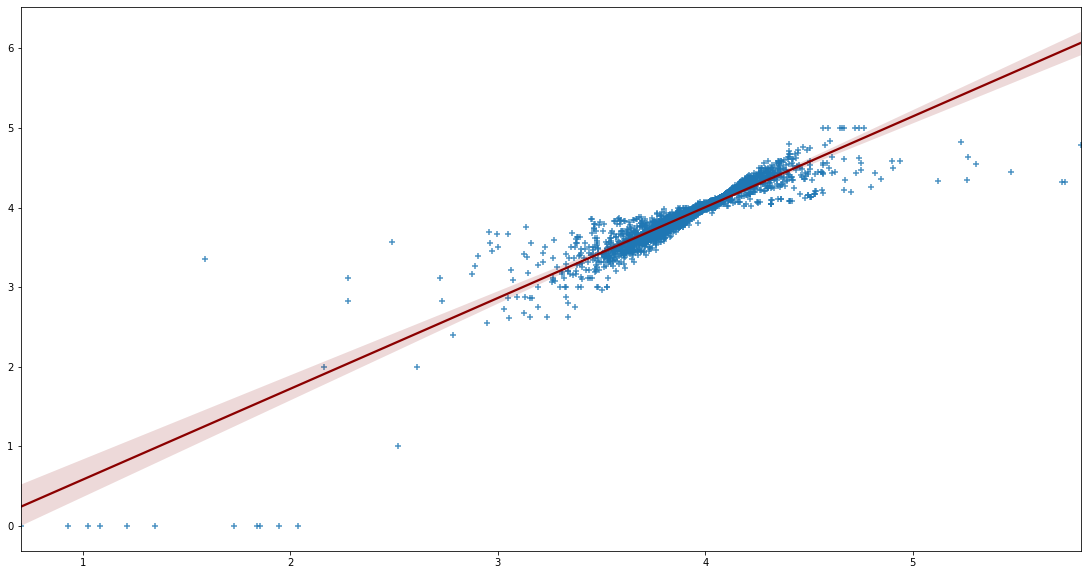

In [35]:
plt.figure(figsize=(19,10))
sns.regplot(pred_ridge,y_test, marker="+", line_kws={'color':'darkred','alpha':1.0})

## Random Forest Model

In [36]:
# Random Forest Model
pred_rf = grad_rf.predict(X_test)

# Check Model Score
print("Residual sum of squares: ",  np.mean((pred_rf - y_test) ** 2))
print('RMSE: '+str(np.sqrt(mean_squared_error(y_test, pred_rf))))
print('Model Score on Test Data: ', grad_rf.score(X_test, y_test))

Residual sum of squares:  0.000760103774874868
RMSE: 0.027569979595111562
Model Score on Test Data:  0.9947206042469382


#### Features Importance

In [37]:
perm = PermutationImportance(grad_ridge.best_estimator_, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
38.1688 ± 1.4985,rate_occ
37.5878 ± 1.0949,num_occ
10.7567 ± 0.2695,rate_per_pages
9.8684 ± 0.1707,num_pages
0.6057 ± 0.0113,ratings_count
0.5826 ± 0.0148,rate_weight_2
0.3231 ± 0.0044,text_reviews_count
0.3156 ± 0.0115,rate_weight
0.0003 ± 0.0004,language_code
-0.0001 ± 0.0001,year


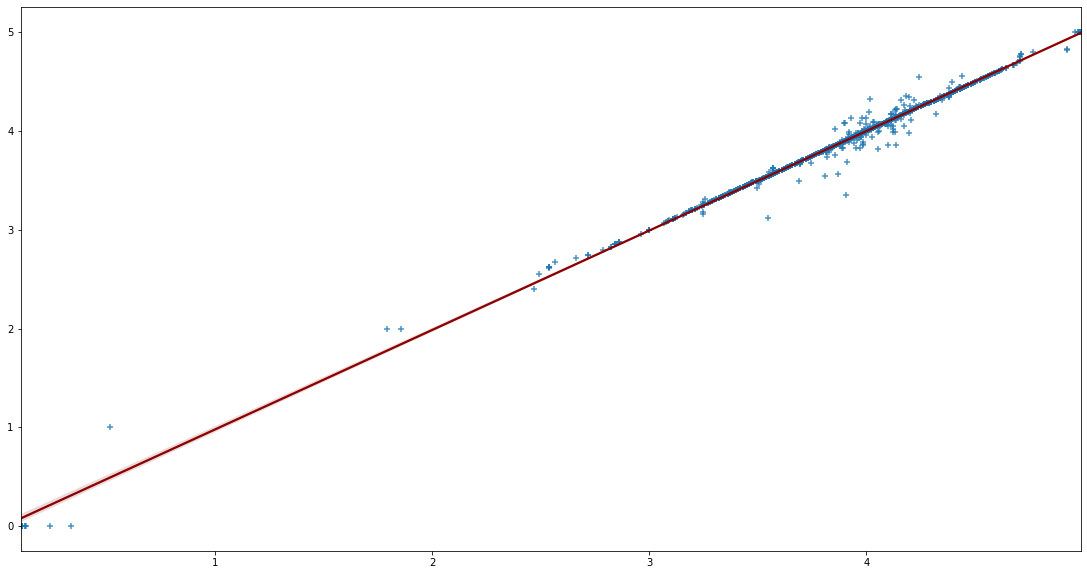

In [38]:
plt.figure(figsize=(19,10))
sns.regplot(pred_rf,y_test, marker="+", line_kws={'color':'darkred','alpha':1.0})

In [39]:
l2 = []
l2.append(('AdaBoost', grad_Ada.score(X_test, y_test)*100))
l2.append(('Linear Regression', grad_Linear.score(X_test, y_test)*100))
l2.append(('Ridge Regression', grad_ridge.score(X_test, y_test)*100))
l2.append(('Random Forest', grad_rf.score(X_test, y_test)*100))

test_scores = pd.DataFrame(l2, columns =['Model', 'Test Score'])

In [40]:
scores['Test Score'] = test_scores['Test Score']
scores

,Model,Train Score,Test Score
0,AdaBoost,93.633126,95.622242
1,Linear Regression,79.382739,83.413543
2,Ridge Regression,79.385106,83.180102
3,Random Forest,98.941485,99.472060


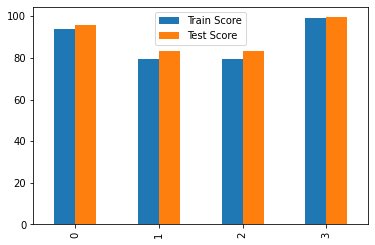

In [41]:
scores.plot.bar()